In [1]:
from framework import StandardScaler
from dql import DQLAgent, DQLTrainer
from ddpg import DDPGAgent, DDPGTrainer, LichtenbergAgent

from PIL import Image
import gym
import numpy as np

def to_gif(matrices, filepath, duration=25):
    frames = []
    for matrix in matrices:
        image = Image.fromarray(matrix)
        frames.append(image)
    frames[0].save(filepath, save_all=True, append_images=frames[1:], duration=duration, loop=0)

## Submarine

In [2]:
from environments.submarine import ContinuousSubmarine
import time

episodes = []
time_taken = []
env = ContinuousSubmarine(delta_t=1, randomize=False) 
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
featurizer = StandardScaler(state_dim, learn=False)
featurizer.mean = np.array([ 7.73739964, 11.54841878,  1.6379028 ,  1.92430292])
featurizer.var = np.array([ 580.12531577, 1460.05771442,   36.57866531,   37.08183991])
# for training comparison stability, ensure that the featurizer scaling is constant

In [ ]:
for _ in range(1):
    # agent = DDPGAgent(state_dim, action_dim, batch_size=32, tau=0.05)
    agent = LichtenbergAgent(state_dim, action_dim, "figure2d.npy", batch_size=32, tau=0.1, n_iter=3, pop=15)

    trainer = DDPGTrainer(env, agent, featurizer, until_convergence=True, convergence_reward=100)
    start = time.perf_counter()
    trainer.train(episodes=10000)
    while not trainer.has_converged(100):
        trainer.train(episodes=100)
    episodes.append(len(trainer.episode_rewards))
    time_taken.append(int(round(time.perf_counter() - start)))
    # print(episodes[-1], time_taken[-1])
    # print(trainer.episode_rewards, trainer.actor_losses, trainer.critic_losses)
    # trainer.plot_losses()
    # trainer.plot_rewards()

## Parking

In [ ]:
import torch
class ParkingFeaturizer(StandardScaler):
    def __init__(self):
        super().__init__(19)
    
    def transform_state(self, state, info=None):
        speed = info['speed'] if info else 0.0
        state = np.concat([state['observation'], state['achieved_goal'], state['desired_goal'], np.array([speed])])
        return torch.tensor(state, dtype=torch.float32).unsqueeze(0)


In [ ]:
import highway_env.envs.parking_env as parking_env

env = parking_env.ParkingEnv({
    "observation": {
        "type": "KinematicsGoal",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": True
    },
    "action": {
        "type": "ContinuousAction"
    },
    "simulation_frequency": 15,
    "policy_frequency": 3,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": True
})
env.render_mode = 'rgb_array'
featurizer = ParkingFeaturizer()
agent = LichtenbergAgent(19, 2, "figure2d.npy", hidden_layers=3, tau=0.05, batch_size=64, n_iter=3, pop=15)
trainer = DDPGTrainer(env, agent, featurizer)

In [ ]:
trainer.train(episodes=10000)
# trainer.save()

## Inverted Pendulum

In [12]:
import torch
class NoisyFeaturizer(StandardScaler):
    def __init__(self, pct_error=0.0):
        super().__init__(8)
        self.noise = pct_error / 2.0
    
    def transform_state(self, state, info=None):
        state = state[:-3] # ignore the constraint forces

        # add noise before normalization
        noise = np.random.normal(0, self.noise, state.shape)

        # propagate error equally to the derived features
        angles = np.arcsin(state[1:3])
        angles_with_error = np.arcsin(self.var[1:3]) * noise[1:3] + angles
        state[1:3] = np.sin(angles_with_error)
        state[3:5] = np.cos(angles_with_error)
        noise[1:5] = 0.0

        state_with_error = noise * self.var + state
        normalized_state = (state_with_error - self.mean) / np.sqrt(self.var + 1e-8)

        return torch.tensor(normalized_state, dtype=torch.float32).unsqueeze(0)

In [13]:
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = DDPGAgent(state_dim, action_dim, hidden_layers=2, tau=0.01, batch_size=256)

featurizer = NoisyFeaturizer()
# experimentally approximated mean and standard deviation of state vector
featurizer.mean = np.array([-0.0537724 , # position of the cart along the linear surface (m)
                             0.00854607, # sine of the angle between the cart and the first pole
                            -0.0020691 , # sine of the angle between the two poles
                             0.97681748, # cosine of the angle between the cart and the first pole
                             0.97418304, # cosine of the angle between the two poles
                             0.00404627, # velocity of the cart (m/s)
                             0.03138314, # angular velocity of the angle between the cart and the first pole (rad/s)
                            -0.03641539, # angular velocity of the angle between the two poles (rad/s)
                            -0.0363062 , # constraint force - 1 (N)
                             0.        , # constraint force - 2 (N)
                             0.          # constraint force - 3 (N)
                             ])[:-3]
featurizer.var = np.array([4.08496608e-02, 9.94629836e-02, 1.39189335e-01, 7.58616097e-03,
                           1.25376890e-02, 6.61337497e+00, 2.03311682e+01, 1.82406234e+01,
                           3.15706362e-02, 0.00000000e+00, 0.00000000e+00])[:-3]

In [37]:
avg_rewards = []
std_rewards = []
convergence_episode = []
error_range = np.linspace(0.0, 0.1, 41) # defines two standard deviations of the gaussian (95% confidence of being within error range)
n = 100 # episodes per test
trials = 5 # number of attempted runs to convergence
for pct_error in error_range:
    for _ in range(trials):
        agent = DDPGAgent(state_dim-3, action_dim, hidden_dim=64, hidden_layers=2, tau=0.1, batch_size=64)
        featurizer.noise = pct_error / 2.0
        trainer = DDPGTrainer(env, agent, featurizer, until_convergence=True, convergence_reward=8000)
        trainer.train(episodes=10000)
        rewards = np.array([trainer.run_episode(False)['reward'] for _ in range(n)])
        avg_rewards.append(np.mean(rewards))
        std_rewards.append(np.std(rewards)/np.sqrt(n))
        convergence_episode.append(len(trainer.episode_rewards))
    # save it
    np.save(f"avg_rewards.npy", avg_rewards)
    np.save(f"std_rewards.npy", std_rewards)
    np.save(f"convergence_episode.npy", convergence_episode)

 23%|██▎       | 2300/10000 [01:03<03:32, 36.30it/s]

Converged at episode 2300



 30%|███       | 3000/10000 [01:58<04:37, 25.25it/s]

Converged at episode 3000



 59%|█████▉    | 5900/10000 [02:43<01:53, 36.09it/s]

Converged at episode 5900



 28%|██▊       | 2800/10000 [01:57<05:01, 23.89it/s]

Converged at episode 2800



 71%|███████   | 7100/10000 [06:19<02:35, 18.71it/s]

Converged at episode 7100



 61%|██████    | 6100/10000 [03:28<02:13, 29.26it/s]

Converged at episode 6100



 53%|█████▎    | 5300/10000 [04:30<03:59, 19.61it/s]

Converged at episode 5300



 74%|███████▍  | 7400/10000 [03:46<01:19, 32.62it/s]

Converged at episode 7400



 53%|█████▎    | 5300/10000 [03:05<02:44, 28.51it/s]

Converged at episode 5300



 62%|██████▏   | 6200/10000 [03:41<02:15, 28.04it/s]

Converged at episode 6200



 52%|█████▏    | 5200/10000 [04:22<04:02, 19.79it/s]

Converged at episode 5200



 60%|██████    | 6000/10000 [03:35<02:23, 27.90it/s]

Converged at episode 6000



 50%|█████     | 5000/10000 [04:11<04:11, 19.84it/s]

Converged at episode 5000



 78%|███████▊  | 7800/10000 [05:52<01:39, 22.15it/s]

Converged at episode 7800



 42%|████▏     | 4156/10000 [01:25<02:00, 48.41it/s]


KeyboardInterrupt: 

In [39]:
error_range*100

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ])

[6774.289912656158,
 7317.352091109585,
 8516.735114989635,
 7504.623933503008,
 2310.810400092554,
 1667.9162646916402,
 1891.821611112335,
 1558.9933733812202,
 835.4529847797332,
 1112.5937609638347,
 901.4429001852617,
 1182.6908965939908,
 1038.3119149375107,
 1002.7834239108686,
 31.154320853076012,
 942.1773636124043]

In [44]:
error_range

array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
       0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.0325, 0.035 , 0.0375,
       0.04  , 0.0425, 0.045 , 0.0475, 0.05  , 0.0525, 0.055 , 0.0575,
       0.06  , 0.0625, 0.065 , 0.0675, 0.07  , 0.0725, 0.075 , 0.0775,
       0.08  , 0.0825, 0.085 , 0.0875, 0.09  , 0.0925, 0.095 , 0.0975,
       0.1   ])

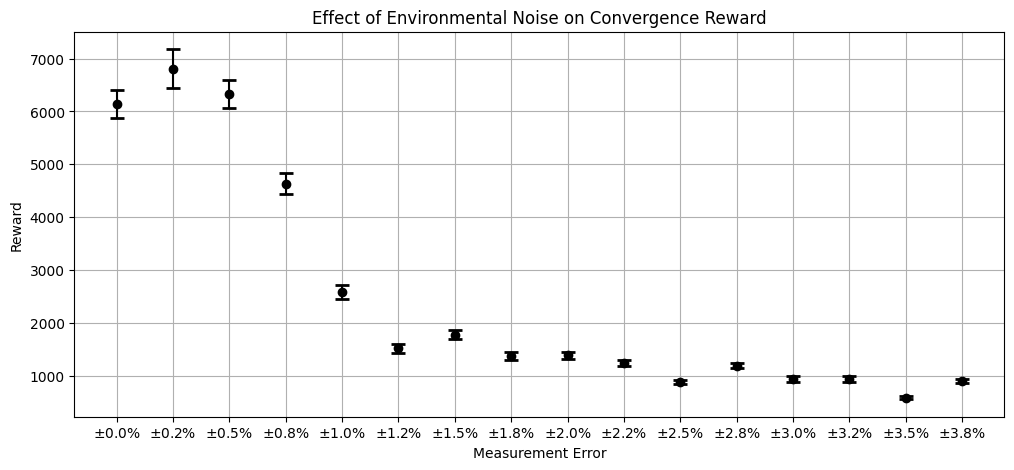

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 5))
X = error_range[:len(avg_rewards[::trials])]
# average every trials clump
y = [np.mean(avg_rewards[i:i+trials]) for i in range(0, len(avg_rewards), trials)]
yerr = [np.mean(std_rewards[i:i+trials]) for i in range(0, len(std_rewards), trials)]
ax.errorbar(X, y, yerr=yerr, fmt="o", capsize=5, capthick=2, color="black")
# ax.plot(n, r_mean, color="black", alpha=0.5)

ax.set_xlabel("Measurement Error")
ax.set_ylabel("Reward")
ax.set_title("Effect of Environmental Noise on Convergence Reward")
# change the font and make the x axis have more ticks and percent sign
ax.set_xticks(X)
ax.set_xticklabels(["$\pm${:.1f}%".format(x*100) for x in X])

ax.grid()
plt.show()

## Ball and Beam Problem

In [ ]:
import ballbeam_gym.envs
import warnings
warnings.filterwarnings('ignore')

env = ballbeam_gym.envs.BallBeamSetpointEnv(timestep=0.02, setpoint=-0.8, beam_length=2.0, max_angle=0.5, max_timesteps=500, action_mode='discrete')
env.action_space = np.arange(3)
state_dim = env.observation_space.shape[0]

featurizer = StandardScaler(state_dim)
agent = DQLAgent(state_dim, env.action_space.shape[0], batch_size=128, epsilon_decay=0.9995)

In [ ]:
trainer = DQLTrainer(env, agent, featurizer)
trainer.train(episodes=1000)
trainer.plot_losses()

In [ ]:
info = trainer.run_episode()
to_gif(info['rgb_arrays'], 'ball_and_beam.gif', duration=25)

## Panda Reach

In [3]:
import torch
class PandaFeaturizer(StandardScaler):
    def __init__(self):
        super().__init__(12)
    
    def transform_state(self, state, info=None):
        state = np.concatenate([state['achieved_goal'], state['desired_goal'], state['observation']])
        return torch.tensor(state, dtype=torch.float32).unsqueeze(0)

In [ ]:
import gymnasium 
import panda_gym
env = gymnasium.make('PandaReach-v3', render_mode="rgb_array")
featurizer = PandaFeaturizer()
agent = DDPGAgent(12, env.action_space.shape[0])
trainer = DDPGTrainer(env, agent, featurizer)
